# Explanation

<p style="color: red;">Note that this calculation of the effective signal strength $\theta_1$ is no longer what we think is accurate!</p>

Based on "Free convolution with a semicircular distribution and eigenvalues of spiked deformations of Wigner matrices", Capitaine et al.

We have $Y = \hat{A} + D$ where $\hat{A}_{ij} = (2A_{ij} - 1) / \sqrt{n}$, so that the entrywise variance is $\sigma^2 = 1$ <span style="color: red;">(cf our discussion of their complex noise distribution)</span>.
We can add back the "missing block" in the planted model without affecting the spectrum asymptotically.
The signal part of $A$ in the planted model is $\mathbb{E}[\hat{A} \mid S] = \frac{1}{\sqrt{n}}1_S1_S^{\top} = \frac{|S|}{\sqrt{n}} \hat{1}_S\hat{1}_S^{\top} = c \hat{1}_S\hat{1}_S^{\top}$.

In the null model $D_{ii} = \sigma(g_i)$, while in the planted model on the planted coordinates $(i \in S)$ we instead have $D_{ii} = \sigma(c + g_i)$.
So, the "extra signal" is of the form $\sum_{i \in S} (\mathbb{E}_g \sigma(c + g))e_ie_i^{\top}$.
In total then, the signal is like $(c + \mathbb{E}_g \sigma(c + g))\hat{1}_S\hat{1}_S^{\top}$.
I think probably we can ignore the other "little signals", since, in the language of the paper above, they will converge to values that are in the support of the noise distribution.

So, we want to plug this signal into the setup of that paper, where $\sigma^2 = 1$ (if I'm understanding correctly), $\nu = \sigma(\mathcal{N}(0, 1))$, and $\theta_1 = c + \mathbb{E}_g \sigma(c + g)$.

I think this boils down to calculating
$$ g_{\nu}(z) = \mathbb{E}_g \frac{1}{z - \sigma(g)}. $$
Then, the "subordination function" involved is
$$ H_{\sigma, \nu}(z) = z + g_{\nu}(z) = z + \mathbb{E}_g \frac{1}{z - \sigma(g)}, $$
and the derivative is
$$ H_{\sigma, \nu}^{\prime}(z) = 1 - \mathbb{E}_g \frac{1}{(z - \sigma(g))^2} $$
So the evaluation we are interested in is
$$ H^{\prime}_{\sigma, \nu}(\theta_1) = 1 - \mathbb{E}_g \frac{1}{(c + \mathbb{E}_g \sigma(c + g) - \sigma(g))^2} $$
In particular, there will be an outlier once $H^{\prime}_{\sigma, \nu}(\theta_1) > 0$, or
$$ \mathbb{E}_g \frac{1}{(c + \mathbb{E}_g \sigma(c + g) - \sigma(g))^2} < 1$$

# Code

In [2]:
import numpy as np
import scipy as sp
import scipy.integrate
import matplotlib.pyplot as plt

In [8]:
def style_ax(ax):
    ax.grid(alpha=0.3)
    ax.set_axisbelow(True)
    ax.minorticks_on()
    
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amssymb} \usepackage{bm}')

<ipython-input-20-ce64642da95d>:15: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return sp.integrate.quad(
<ipython-input-20-ce64642da95d>:15: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return sp.integrate.quad(
<ipython-input-20-ce64642da95d>:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return sp.integrate.quad(


Critical c: 0.9238476953907815


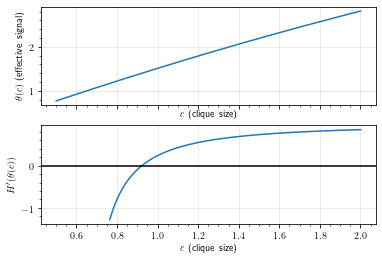

In [20]:
def sigma(x):
    # return np.tanh(x / 2) / 2
    return x / np.sqrt(1.0 + x ** 2)
    # return np.minimum(1.0, np.maximum(-1.0, x)) / 2
    # return np.tanh(4 * x) / 4
    # return (2*x ** 3 - 3*x) * np.exp(-x ** 2 / 2) / (np.sqrt(3) * np.pi ** 0.25)

# Approximate range:
test_xs = np.linspace(-10, 10, 100)
image = [np.min(sigma(test_xs)), np.max(sigma(test_xs))]


def gaussian_integral(f):
    """General calculation of E[f(x)] for x ~ N(0, 1)."""
    return sp.integrate.quad(
        lambda x: f(x) * np.exp(-x ** 2 / 2.0) / np.sqrt(2.0 * np.pi), 
        float('-inf'), float('inf'))[0]


def theta(c):
    """Effective signal for a given clique size c = |S| / sqrt(n)."""
    return c + gaussian_integral(lambda x: sigma(c + x))


def H(z):
    """Subordination function."""
    return z + gaussian_integral(lambda x: 1 / (z - sigma(x)))


def H_prime(z):
    """Subordination function derivative."""
    return 1.0 - gaussian_integral(lambda x: 1 / (z - sigma(x)) ** 2)


N = 500
cs = np.linspace(0.5, 2.0, N)
thetas = np.array([theta(c) for c in cs])

# Hack to try to avoid blow-up around edges:
l = [i for i in range(N) if image[0] < thetas[i] and thetas[i] < image[1]]
if l:
    i_crit = np.max(l)
else:
    i_crit = 1
i_crit = i_crit + 40

vals_H_prime = np.array([H_prime(theta(c)) for c in cs])
for c, val in zip(cs, vals_H_prime):
    if val > 0.0:
        critical_c = c
        break
print('Critical c:', critical_c)
# vals_H = np.array([H(c) for c in cs])

fig, axes = plt.subplots(2, 1, sharex=True)

axes[0].plot(cs, thetas)
axes[0].set_xlabel('$c$ (clique size)')
axes[0].set_ylabel('$\\theta(c)$ (effective signal)')

axes[1].plot(cs[i_crit:], vals_H_prime[i_crit:])
axes[1].set_xlabel('$c$ (clique size)')
axes[1].set_ylabel('$H^{\\prime}(\\theta(c))$')

plt.axhline(0.0, color='black')

for ax in axes:
    style_ax(ax)

# Montanari-Deshpande belief propagation threshold:
# plt.axvline(np.sqrt(1.0 / np.e), color='black')